# HSE Convergence

Here we explore the convergence of the HSE well-balanced method.

We use reflecting boundary conditions and the `HSEPPMInterpolant` reconstruction of the pressure.

In [1]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
from ppmpy.initial_conditions import hse

import matplotlib.pyplot as plt
import numpy as np

## Convergence testing with HSE reconstruction

In [2]:
params = {"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0}

In [3]:
simulations = []
for nx in [32, 64, 128, 256, 512]:
    dt = 0.015625 * (32 / nx)
    e = Euler(nx, 0.5, fixed_dt=dt, init_cond=hse, grav_func=constant_gravity,
              use_limiting=True, use_flattening=True,
              use_hse_reconstruction=True,
              bc_left_type="reflect", bc_right_type="reflect", params=params)
    e.evolve(0.5, verbose=False)
    simulations.append(e)

Richardson convergence testing--compare adjacent resolution runs.

In [4]:
from itertools import pairwise
ivar = 0

In [5]:
for coarse, fine in pairwise(simulations):
    _, cd = fine.grid.coarsen(fine.U[:, ivar])
    err = coarse.grid.norm(coarse.U[:, ivar] - cd)
    print(f"{fine.grid.nx:3d} -> {coarse.grid.nx:3d} : {err}")

 64 ->  32 : 3.6537626526206627e-05
128 ->  64 : 9.208712352368843e-06
256 -> 128 : 2.3117807006939062e-06
512 -> 256 : 5.794725187474326e-07


Compare to the initial conditions.  If we were in HSE, then the density should be the same as it was originally.

In [6]:
for s in simulations:
    print(f"{s.grid.nx:3d} : {s.grid.norm(s.U_init[:, ivar] - s.U[:, ivar]) }")

 32 : 1.5642584519965996e-05
 64 : 3.955429302849995e-06
128 : 9.94413687738086e-07
256 : 2.5011318512955466e-07
512 : 6.259701007232347e-08


Visualize the atmosphere at the start and end.

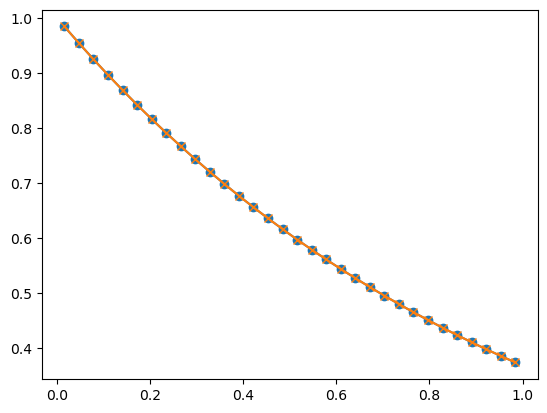

In [7]:
s = simulations[0]

fig, ax = plt.subplots()
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], s.U_init[s.grid.lo:s.grid.hi+1, ivar], marker="o")
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], s.U[s.grid.lo:s.grid.hi+1, ivar], marker="x")

## Convergence of the well-balanced method

Now we do the same for the reconstruction that does the characteristic tracing only on
the pressure perturbation.

In [8]:
simulations = []
for nx in [32, 64, 128, 256, 512]:
    dt = 0.015625 * (32 / nx)
    e = Euler(nx, 0.5, fixed_dt=dt, init_cond=hse, grav_func=constant_gravity,
              use_limiting=True, use_flattening=True,
              use_hse_reconstruction=True, hse_as_perturbation=True,
              bc_left_type="reflect", bc_right_type="reflect", params=params)
    e.evolve(0.5, verbose=False)
    simulations.append(e)

In [9]:
for coarse, fine in pairwise(simulations):
    _, cd = fine.grid.coarsen(fine.U[:, ivar])
    err = coarse.grid.norm(coarse.U[:, ivar] - cd)
    print(f"{fine.grid.nx:3d} -> {coarse.grid.nx:3d} : {err}")

 64 ->  32 : 3.4760439589959424e-05
128 ->  64 : 8.776428605358436e-06
256 -> 128 : 2.204958615561335e-06
512 -> 256 : 5.525999756839299e-07


As expected, this also converges 2nd-order.